In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Imagen 3 Customized Images

## Overview

### Imagen 3

Imagen 3 on Vertex AI brings Google's state of the art generative AI capabilities to application developers. Imagen 3 is Google's highest quality text-to-image model to date. It's capable of creating images with astonishing detail. Thus, developers have more control when building next-generation AI products that transform their imagination into high quality visual assets. Learn more about [Imagen on Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/image/overview).

In this tutorial, you will learn how to use the Google Gen AI SDK for Python to generate customized images using few-shot learning with Imagen 3. You'll supply a text prompt and reference images to guide new image generation in the following styles:

- Subject customization
- Style transfer
- Style customization
- Controlled customization
  - Canny edge
  - Scribble

## Get started


### Install Google Gen AI SDK for Python


In [1]:
%pip install --upgrade --quiet google-genai opencv-python ipycanvas ipywidgets

Note: you may need to restart the kernel to use updated packages.


### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment.


In [ ]:
import sys

if "google.colab" in sys.modules:
    # Support for third party widgets
    from google.colab import auth, output

    auth.authenticate_user()
    output.enable_custom_widget_manager()

### Import libraries

In [2]:
import urllib

from IPython.display import display
from PIL import Image as PIL_Image
from google import genai
from google.genai.types import (
    ControlReferenceConfig,
    ControlReferenceImage,
    EditImageConfig,
    GenerateImagesConfig,
    Image,
    RawReferenceImage,
    StyleReferenceConfig,
    StyleReferenceImage,
    SubjectReferenceConfig,
    SubjectReferenceImage,
)
from ipycanvas import Canvas
from ipywidgets import Button
import matplotlib.pyplot as plt

### Set Google Cloud project information and create client

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [3]:
import os

PROJECT_ID = "qwiklabs-gcp-00-8ecf57b550c3"  # @param {type: "string", placeholder: "[your-project-id]", isTemplate: true}
if not PROJECT_ID or PROJECT_ID == "[your-project-id]":
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-central1")

client = genai.Client(vertexai=True, project=PROJECT_ID, location=LOCATION)

### Define a helper function to display images

In [4]:
def display_images(generated_image, ref_image) -> None:
    fig, axis = plt.subplots(1, 2, figsize=(12, 6))
    axis[0].imshow(generated_image)
    axis[0].set_title("Imagen 3")
    axis[1].imshow(ref_image)
    axis[1].set_title("Reference Image")
    for ax in axis:
        ax.axis("off")
    plt.show()

### Load the image models

Imagen 3 Customization: `imagen-3.0-capability-001`

Imagen 3 Generation: `imagen-3.0-generate-002`

In [5]:
customization_model = "imagen-3.0-capability-001"
generation_model = "imagen-3.0-generate-002"

### Subject customization

Few-shot prompting with Imagen 3 Customization supports the following subjects: animal companion, person, and product. The following example demonstrates how to customize images of a person. To do this create 1 - 4 `SubjectReferenceImage` objects with the `subject_type` set to SUBJECT_TYPE_PERSON. For subject customization involving people you can also create a ```ControlReferenceImage``` with the `control_type` set to CONTROL_TYPE_FACE_MESH. Passing in a control reference image will allow you to better specify the face position in the edited image.

Next, draft a prompt for the new image and make sure to reference the subject in the prompt by including brackets with the reference id you assigned to each reference image.

When generating images you can also set the `safety_filter_level` and `person_generation` parameters accordingly:
* `person_generation`: 
  * `DONT_ALLOW`, `ALLOW_ADULT`,`ALLOW_ALL`
* `safety_filter_level`:
  * `BLOCK_LOW_AND_ABOVE`, `BLOCK_MEDIUM_AND_ABOVE`, `BLOCK_ONLY_HIGH`, `BLOCK_NONE`

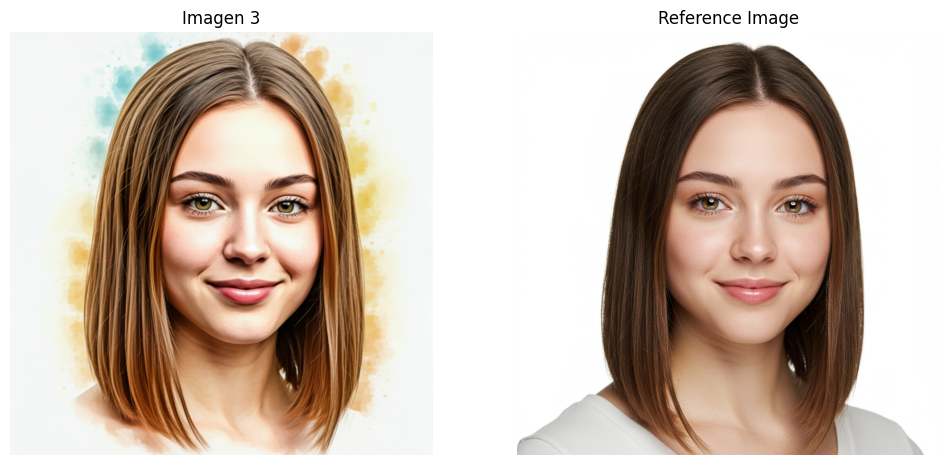

In [7]:
subject_image = Image(gcs_uri="gs://cloud-samples-data/generative-ai/image/person.png")

subject_reference_image = SubjectReferenceImage(
    reference_id=1,
    reference_image=subject_image,
    config=SubjectReferenceConfig(
        subject_description="a headshot of a woman", subject_type="SUBJECT_TYPE_PERSON"
    ),
)

control_reference_image = ControlReferenceImage(
    reference_id=2,
    reference_image=subject_image,
    config=ControlReferenceConfig(control_type="CONTROL_TYPE_FACE_MESH"),
)

prompt = "a portrait of a woman[1] in the pose of the control image[2] in a watercolor style by a professional artist, light and low-contrast stokes, bright pastel colors, blue and yellow preffered, a warm atmosphere, clean background, grainy paper, bold visible brushstrokes, patchy details"

image = client.models.edit_image(
    model=customization_model,
    prompt=prompt,
    reference_images=[subject_reference_image, control_reference_image],
    config=EditImageConfig(
        edit_mode="EDIT_MODE_DEFAULT",
        number_of_images=1,
        seed=1,
        safety_filter_level="BLOCK_MEDIUM_AND_ABOVE",
        person_generation="ALLOW_ADULT",
    ),
)

image_show = PIL_Image.open(
    urllib.request.urlopen(
        "https://storage.googleapis.com/cloud-samples-data/generative-ai/image/person.png"
    )
)

display_images(image.generated_images[0].image._pil_image, image_show)

### Style transfer

You can also transfer image styles with Imagen 3 Customization. This entails recreating reference images in a new style based on your text prompt.

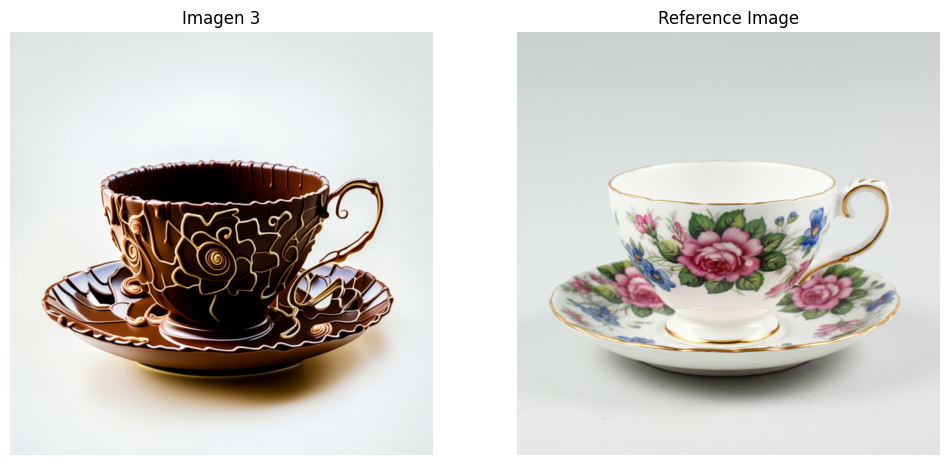

In [8]:
image = Image(gcs_uri="gs://cloud-samples-data/generative-ai/image/teacup-1.png")

raw_ref_image = RawReferenceImage(reference_image=image, reference_id=1)

prompt = "transform the subject in the image so that the teacup[1] is made entirely out of chocolate"

style_image = client.models.edit_image(
    model=customization_model,
    prompt=prompt,
    reference_images=[raw_ref_image],
    config=EditImageConfig(
        edit_mode="EDIT_MODE_DEFAULT",
        number_of_images=1,
        seed=1,
        safety_filter_level="BLOCK_MEDIUM_AND_ABOVE",
        person_generation="ALLOW_ADULT",
    ),
)

image_show = PIL_Image.open(
    urllib.request.urlopen(
        "https://storage.googleapis.com/cloud-samples-data/generative-ai/image/teacup-1.png"
    )
)

display_images(style_image.generated_images[0].image._pil_image, image_show)

### Style customization

With style customization, you can add reference images and craft a text prompt to transfer the style of the referenced images to new images. You can do this by creating ```StyleReferenceImage``` objects.

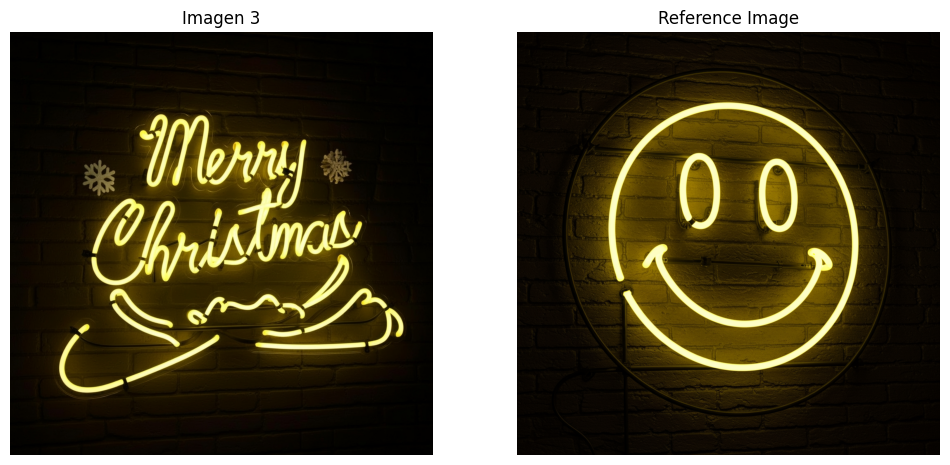

In [12]:
style_image = Image(gcs_uri="gs://cloud-samples-data/generative-ai/image/neon.png")

style_reference_image = StyleReferenceImage(
    reference_id=1,
    reference_image=style_image,
    config=StyleReferenceConfig(style_description="neon sign"),
)

prompt = "generate an image of a neon sign [1] with the words: Merry Christmas !"

style_customization = client.models.edit_image(
    model=customization_model,
    prompt=prompt,
    reference_images=[style_reference_image],
    config=EditImageConfig(
        edit_mode="EDIT_MODE_DEFAULT",
        number_of_images=1,
        seed=1,
        safety_filter_level="BLOCK_MEDIUM_AND_ABOVE",
        person_generation="ALLOW_ADULT",
    ),
)

image_show = PIL_Image.open(
    urllib.request.urlopen(
        "https://storage.googleapis.com/cloud-samples-data/generative-ai/image/neon.png"
    )
)

display_images(style_customization.generated_images[0].image._pil_image, image_show)

### Controlled customization

Controlled customization allows you to turn sketches into fully realized images. Imagen 3 Controlled Customization creates new images based on a source image signal or a source image (canny edge/scribble).

#### Canny edge

Generate a new image with Imagen 3, apply the Canny Edge filter, and generate a new image based on this ```ControlReferenceImage```.


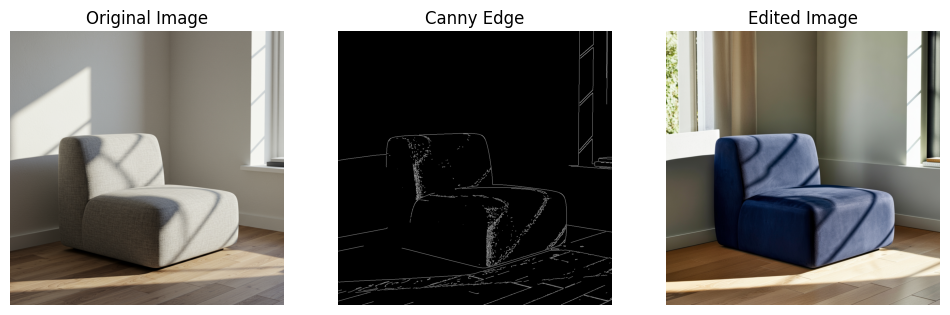

In [13]:
import cv2

generation_prompt = """
a simple accent chair in a neutral color
"""
generated_image = client.models.generate_images(
    model=generation_model,
    prompt=generation_prompt,
    config=GenerateImagesConfig(
        number_of_images=1,
        aspect_ratio="1:1",
        safety_filter_level="BLOCK_MEDIUM_AND_ABOVE",
        person_generation="DONT_ALLOW",
    ),
)

generated_image.generated_images[0].image.save("chair.png")
img = cv2.imread("chair.png")

# Setting parameter values
t_lower = 100  # Lower Threshold
t_upper = 150  # Upper threshold

# Applying the Canny Edge filter
edge = cv2.Canny(img, t_lower, t_upper)
cv2.imwrite("chair_edge.png", edge)

control_image = ControlReferenceImage(
    reference_id=1,
    reference_image=Image.from_file(location="chair_edge.png"),
    config=ControlReferenceConfig(control_type="CONTROL_TYPE_CANNY"),
)

edit_prompt = "A photorealistic image along the lines of a navy suede accent chair in a living room, near big windows"

control_image = client.models.edit_image(
    model=customization_model,
    prompt=edit_prompt,
    reference_images=[control_image],
    config=EditImageConfig(
        edit_mode="EDIT_MODE_CONTROLLED_EDITING",
        number_of_images=1,
        safety_filter_level="BLOCK_MEDIUM_AND_ABOVE",
        person_generation="DONT_ALLOW",
    ),
)

fig, axis = plt.subplots(1, 3, figsize=(12, 6))
axis[0].imshow(generated_image.generated_images[0].image._pil_image)
axis[0].set_title("Original Image")
axis[1].imshow(edge, cmap="gray")
axis[1].set_title("Canny Edge")
axis[2].imshow(control_image.generated_images[0].image._pil_image)
axis[2].set_title("Edited Image")
for ax in axis:
    ax.axis("off")
plt.show()

#### Scribble

In order to use Controlled Customization with a scribble source image you need to supply a control image with a black background and white lines. Run the following cells to generate a canvas where you can draw a scribble image with your mouse. Once complete, click the 'Save Image' button, rename the file to `snippet.png` to save your scribble image locally.

In [14]:
from IPython.display import display, HTML

display(HTML("""
<canvas id="myCanvas" width="400" height="300" style="border:1px solid #000000; background-color:white;"></canvas>
<br>
<button onclick="clearCanvas()">Clear Canvas</button>
<button onclick="saveCanvas()">Save Image</button>
<div id="imageOutput"></div>
<script>
var canvas = document.getElementById("myCanvas");
var ctx = canvas.getContext("2d");
ctx.strokeStyle = "black";
ctx.lineWidth = 3;

var drawing = false;

canvas.addEventListener("mousedown", function(e) {
    drawing = true;
    ctx.beginPath();
    ctx.moveTo(e.offsetX, e.offsetY);
});

canvas.addEventListener("mousemove", function(e) {
    if (drawing) {
        ctx.lineTo(e.offsetX, e.offsetY);
        ctx.stroke();
    }
});

canvas.addEventListener("mouseup", function(e) {
    drawing = false;
});

function clearCanvas() {
    ctx.fillStyle = "white";
    ctx.fillRect(0, 0, canvas.width, canvas.height);
}

function saveCanvas() {
    var link = document.createElement('a');
    link.download = 'snippet.png';
    link.href = canvas.toDataURL();
    link.click();
}
</script>
"""))

Click on the upload icon, select the `snippet.png` file and click on __Upload__.

In the following cell, provide a description of the image you created earlier in the canvas. This description will be used as a prompt to create a new image.

In [18]:
## Provide a description of the image you've drawn
prompt = "A happy heart" # Eg. A ball on the beach

Supply your scribble image as a ```ControlReferenceImage``` and create a new image by calling ```edit_image```.

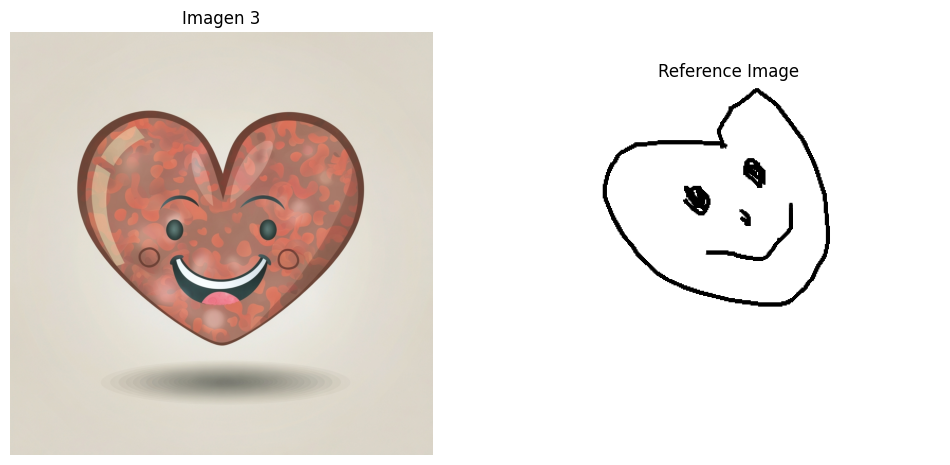

In [19]:
control_ref_image = ControlReferenceImage(
    reference_id=1,
    reference_image=Image.from_file(location="snippet.png"),
    config=ControlReferenceConfig(control_type="CONTROL_TYPE_SCRIBBLE"),
)

control_image = client.models.edit_image(
    model=customization_model,
    prompt=prompt,
    reference_images=[control_ref_image],
    config=EditImageConfig(
        edit_mode="EDIT_MODE_CONTROLLED_EDITING",
        number_of_images=1,
        safety_filter_level="BLOCK_MEDIUM_AND_ABOVE",
        person_generation="DONT_ALLOW",
    ),
)

display_images(
    control_image.generated_images[0].image._pil_image, PIL_Image.open("snippet.png")
)